In [1]:
from google.colab import drive
drive.mount('/content/drive')
import skimage
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import pandas as pd
from PIL import Image
import torch
import torchvision
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import tqdm
from tqdm import tqdm_notebook
os.chdir('/content/drive/My Drive/amit sethi')

ROOT_DIR = os.path.abspath("../../")
sys.path.append(ROOT_DIR)

# Data Path
TEST_PATH = 'Datasets/test/'
TRAIN_PATH = 'Datasets/nucleus/'

# Get train and test IDs
test_ids = next(os.walk(TEST_PATH))[1]
train_ids = next(os.walk(TRAIN_PATH))[1]

%matplotlib inline 

# Root directory of the project
torch.cuda.empty_cache()
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "/content/drive/My Drive/amit sethi/logs")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#### Defining Dataset ####

class NucleusDataset(torch.utils.data.Dataset):
  def __init__(self, images, masks, train = True):
    
    self.images = images
    self.masks = masks
    self.train = train


  def transforms(self, image, mask):

    if random.random() > 0.5:
      image = TF.hflip(image)
      mask = TF.hflip(mask)

    if random.random() > 0.5:
      image = TF.hflip(image)
      mask = TF.hflip(mask)

    if random.random() > 0.8:
      image = TF.affine(image, 90, (100,100), 1.0, 45.0)
      mask = TF.affine(mask, 90, (100,100), 1.0, 45.0)

    image = TF.to_tensor(image)
    mask = TF.to_tensor(mask)

    return image,mask


  def __len__(self):
    return len(self.images)

  def __getitem__(self,index): 

    image = self.images[index]
    mask = self.masks[index]

    if self.train:
      x,y = self.transforms(image, mask)

    else:
      x = TF.to_tensor(image)
      y = TF.to_tensor(mask)

    return x,y

In [0]:
### utility functions ###

def train_creator(ids, root):
  images = []
  masks = []

  for i in range(len(ids)):

    image_name = root + ids[i] + '/images/' + ids[i] + '.png'
    mask_name = root + ids[i] + '/masks/' + ids[i] + '.png'
    original_image = Image.open(image_name)
    original_mask = Image.open(mask_name)

    width, height = original_image.size
    for i in range(0,height,200):
      for j in range(0,width,200):
        box = (j,i,j+200, i+200)
        image = original_image.crop(box)
        mask = original_mask.crop(box)
        images.append(image)
        masks.append(mask)
    
  return images, masks

def predict(model, dataloader):
  image, masks = next(iter(dataloader))
  length = len(dataloader)
  outputs = model(image.cuda())

  return image,outputs, masks

def show(img):
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [0]:
BatchNorm2d = nn.BatchNorm2d
BN_MOMENTUM = 0.01

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = BatchNorm2d(planes * self.expansion,
                               momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class HighResolutionModule(nn.Module):
    def __init__(self, num_branches, blocks, num_blocks, num_inchannels,
                 num_channels, fuse_method, multi_scale_output=True):
        super(HighResolutionModule, self).__init__()
        self._check_branches(
            num_branches, blocks, num_blocks, num_inchannels, num_channels)

        self.num_inchannels = num_inchannels
        self.fuse_method = fuse_method
        self.num_branches = num_branches

        self.multi_scale_output = multi_scale_output

        self.branches = self._make_branches(
            num_branches, blocks, num_blocks, num_channels)
        self.fuse_layers = self._make_fuse_layers()
        self.relu = nn.ReLU(inplace=True)

    def _check_branches(self, num_branches, blocks, num_blocks,
                        num_inchannels, num_channels):
        if num_branches != len(num_blocks):
            error_msg = 'NUM_BRANCHES({}) <> NUM_BLOCKS({})'.format(
                num_branches, len(num_blocks))
            raise ValueError(error_msg)

        if num_branches != len(num_channels):
            error_msg = 'NUM_BRANCHES({}) <> NUM_CHANNELS({})'.format(
                num_branches, len(num_channels))
            raise ValueError(error_msg)

        if num_branches != len(num_inchannels):
            error_msg = 'NUM_BRANCHES({}) <> NUM_INCHANNELS({})'.format(
                num_branches, len(num_inchannels))
            raise ValueError(error_msg)

    def _make_one_branch(self, branch_index, block, num_blocks, num_channels,
                         stride=1):
        downsample = None
        if stride != 1 or \
           self.num_inchannels[branch_index] != num_channels[branch_index] * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.num_inchannels[branch_index],
                          num_channels[branch_index] * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm2d(num_channels[branch_index] * block.expansion,
                            momentum=BN_MOMENTUM),
            )

        layers = []
        layers.append(block(self.num_inchannels[branch_index],
                            num_channels[branch_index], stride, downsample))
        self.num_inchannels[branch_index] = \
            num_channels[branch_index] * block.expansion
        for i in range(1, num_blocks[branch_index]):
            layers.append(block(self.num_inchannels[branch_index],
                                num_channels[branch_index]))

        return nn.Sequential(*layers)

    def _make_branches(self, num_branches, block, num_blocks, num_channels):
        branches = []

        for i in range(num_branches):
            branches.append(
                self._make_one_branch(i, block, num_blocks, num_channels))

        return nn.ModuleList(branches)

    def _make_fuse_layers(self):
        if self.num_branches == 1:
            return None

        num_branches = self.num_branches
        num_inchannels = self.num_inchannels
        fuse_layers = []
        for i in range(num_branches if self.multi_scale_output else 1):
            fuse_layer = []
            for j in range(num_branches):
                if j > i:
                    fuse_layer.append(nn.Sequential(
                        nn.Conv2d(num_inchannels[j],
                                  num_inchannels[i],
                                  1,
                                  1,
                                  0,
                                  bias=False),
                        BatchNorm2d(num_inchannels[i], momentum=BN_MOMENTUM)))
                elif j == i:
                    fuse_layer.append(None)
                else:
                    conv3x3s = []
                    for k in range(i-j):
                        if k == i - j - 1:
                            num_outchannels_conv3x3 = num_inchannels[i]
                            conv3x3s.append(nn.Sequential(
                                nn.Conv2d(num_inchannels[j],
                                          num_outchannels_conv3x3,
                                          3, 2, 1, bias=False),
                                BatchNorm2d(num_outchannels_conv3x3, 
                                            momentum=BN_MOMENTUM)))
                        else:
                            num_outchannels_conv3x3 = num_inchannels[j]
                            conv3x3s.append(nn.Sequential(
                                nn.Conv2d(num_inchannels[j],
                                          num_outchannels_conv3x3,
                                          3, 2, 1, bias=False),
                                BatchNorm2d(num_outchannels_conv3x3,
                                            momentum=BN_MOMENTUM),
                                nn.ReLU(inplace=True)))
                    fuse_layer.append(nn.Sequential(*conv3x3s))
            fuse_layers.append(nn.ModuleList(fuse_layer))

        return nn.ModuleList(fuse_layers)

    def get_num_inchannels(self):
        return self.num_inchannels

    def forward(self, x):
        if self.num_branches == 1:
            return [self.branches[0](x[0])]

        for i in range(self.num_branches):
            x[i] = self.branches[i](x[i])

        x_fuse = []
        for i in range(len(self.fuse_layers)):
            y = x[0] if i == 0 else self.fuse_layers[i][0](x[0])
            for j in range(1, self.num_branches):
                if i == j:
                    y = y + x[j]
                elif j > i:
                    width_output = x[i].shape[-1]
                    height_output = x[i].shape[-2]
                    y = y + F.interpolate(
                        self.fuse_layers[i][j](x[j]),
                        size=[height_output, width_output],
                        mode='bilinear')
                else:
                    y = y + self.fuse_layers[i][j](x[j])
            x_fuse.append(self.relu(y))

        return x_fuse


blocks_dict = {
    'BASIC': BasicBlock,
    'BOTTLENECK': Bottleneck
}


class HighResolutionNet(nn.Module):

    def __init__(self, config, **kwargs):
        extra = config
        super(HighResolutionNet, self).__init__()

        # stem net
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.bn1 = BatchNorm2d(64, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.bn2 = BatchNorm2d(64, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        
        self.stage1_cfg = extra['STAGE1']
        num_channels = self.stage1_cfg['NUM_CHANNELS'][0]
        block = blocks_dict[self.stage1_cfg['BLOCK']]
        num_blocks = self.stage1_cfg['NUM_BLOCKS'][0]
        self.layer1 = self._make_layer(block, 64, num_channels, num_blocks)
        stage1_out_channel = block.expansion*num_channels

        self.stage2_cfg = extra['STAGE2']
        num_channels = self.stage2_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage2_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition1 = self._make_transition_layer(
            [stage1_out_channel], num_channels)
        self.stage2, pre_stage_channels = self._make_stage(
            self.stage2_cfg, num_channels)

        self.stage3_cfg = extra['STAGE3']
        num_channels = self.stage3_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage3_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition2 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.stage3, pre_stage_channels = self._make_stage(
            self.stage3_cfg, num_channels)

        self.stage4_cfg = extra['STAGE4']
        num_channels = self.stage4_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage4_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition3 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.stage4, pre_stage_channels = self._make_stage(
            self.stage4_cfg, num_channels, multi_scale_output=True)
        
        last_inp_channels = np.int(np.sum(pre_stage_channels))

        self.last_layer = nn.Sequential(
            nn.Conv2d(
                in_channels=last_inp_channels,
                out_channels=last_inp_channels,
                kernel_size=1,
                stride=1,
                padding=0),
            BatchNorm2d(last_inp_channels, momentum=BN_MOMENTUM),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=last_inp_channels,
                out_channels=1,
                kernel_size=extra['FINAL_CONV_KERNEL'],
                stride=1,
                padding=1 if extra['FINAL_CONV_KERNEL'] == 3 else 0)
        )

        self.outputs1 = torch.nn.ConvTranspose2d(1,1,4,2,padding = 1)
        self.outputs2 = torch.nn.ConvTranspose2d(1,1,4,2,padding = 1)
        self.sigmoid = nn.Sigmoid()

    def _make_transition_layer(
            self, num_channels_pre_layer, num_channels_cur_layer):
        num_branches_cur = len(num_channels_cur_layer)
        num_branches_pre = len(num_channels_pre_layer)

        transition_layers = []
        for i in range(num_branches_cur):
            if i < num_branches_pre:
                if num_channels_cur_layer[i] != num_channels_pre_layer[i]:
                    transition_layers.append(nn.Sequential(
                        nn.Conv2d(num_channels_pre_layer[i],
                                  num_channels_cur_layer[i],
                                  3,
                                  1,
                                  1,
                                  bias=False),
                        BatchNorm2d(
                            num_channels_cur_layer[i], momentum=BN_MOMENTUM),
                        nn.ReLU(inplace=True)))
                else:
                    transition_layers.append(None)
            else:
                conv3x3s = []
                for j in range(i+1-num_branches_pre):
                    inchannels = num_channels_pre_layer[-1]
                    outchannels = num_channels_cur_layer[i] \
                        if j == i-num_branches_pre else inchannels
                    conv3x3s.append(nn.Sequential(
                        nn.Conv2d(
                            inchannels, outchannels, 3, 2, 1, bias=False),
                        BatchNorm2d(outchannels, momentum=BN_MOMENTUM),
                        nn.ReLU(inplace=True)))
                transition_layers.append(nn.Sequential(*conv3x3s))

        return nn.ModuleList(transition_layers)

    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm2d(planes * block.expansion, momentum=BN_MOMENTUM),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(inplanes, planes))

        return nn.Sequential(*layers)

    def _make_stage(self, layer_config, num_inchannels,
                    multi_scale_output=True):
        num_modules = layer_config['NUM_MODULES']
        num_branches = layer_config['NUM_BRANCHES']
        num_blocks = layer_config['NUM_BLOCKS']
        num_channels = layer_config['NUM_CHANNELS']
        block = blocks_dict[layer_config['BLOCK']]
        fuse_method = layer_config['FUSE_METHOD']

        modules = []
        for i in range(num_modules):
            # multi_scale_output is only used last module
            if not multi_scale_output and i == num_modules - 1:
                reset_multi_scale_output = False
            else:
                reset_multi_scale_output = True
            modules.append(
                HighResolutionModule(num_branches,
                                      block,
                                      num_blocks,
                                      num_inchannels,
                                      num_channels,
                                      fuse_method,
                                      reset_multi_scale_output)
            )
            num_inchannels = modules[-1].get_num_inchannels()

        return nn.Sequential(*modules), num_inchannels

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.layer1(x)

        x_list = []
        for i in range(self.stage2_cfg['NUM_BRANCHES']):
            if self.transition1[i] is not None:
                x_list.append(self.transition1[i](x))
            else:
                x_list.append(x)
        y_list = self.stage2(x_list)

        x_list = []
        for i in range(self.stage3_cfg['NUM_BRANCHES']):
            if self.transition2[i] is not None:
                x_list.append(self.transition2[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        y_list = self.stage3(x_list)

        x_list = []
        for i in range(self.stage4_cfg['NUM_BRANCHES']):
            if self.transition3[i] is not None:
                x_list.append(self.transition3[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        x = self.stage4(x_list)

        # Upsampling
        x0_h, x0_w = x[0].size(2), x[0].size(3)
        x1 = F.upsample(x[1], size=(x0_h, x0_w), mode='bilinear')
        x2 = F.upsample(x[2], size=(x0_h, x0_w), mode='bilinear')
        x3 = F.upsample(x[3], size=(x0_h, x0_w), mode='bilinear')

        x = torch.cat([x[0], x1, x2, x3], 1)

        x = self.last_layer(x)
        x = self.outputs1(x)
        x = self.outputs2(x)

        x = self.sigmoid(x)

        return x

    def init_weights(self, pretrained='',):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.001)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

def get_seg_model(cfg, **kwargs):
    model = HighResolutionNet(cfg, **kwargs)
    model.init_weights()

    return model

In [0]:
train_images, train_masks = train_creator(train_ids, TRAIN_PATH)
test_images, test_masks = train_creator(test_ids, TEST_PATH)

train_dataset = NucleusDataset(train_images, train_masks, True)
lengths = [int(len(train_images) * 0.8), int(len(train_images) * 0.2)]
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, lengths)
test_dataset = NucleusDataset(test_images, test_masks, False)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 5, shuffle = True, num_workers = 2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 5, shuffle = False, num_workers = 2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 25, shuffle = False, num_workers = 2)

In [0]:
### Training Functions ###

def train(dataloader, model, optimizer, criterion):
  model.train()
  train_losses.append(0)
  progbar = tqdm_notebook(total = len(dataloader), desc = 'HRNet Train')


  for i, (inputs,targets) in enumerate(dataloader):
    optimizer.zero_grad()
    
    inputs, targets = Variable(inputs.cuda()), Variable(targets.cuda())

    outputs = model(inputs)
    error = criterion(outputs, targets)

    error.backward()
    optimizer.step()

    train_losses[-1] = train_losses[-1] + error.data
    progbar.set_description('Train (loss=%.4f)' % (train_losses[-1]/(i+1)))
    progbar.update(1)

  train_losses[-1] = train_losses[-1]/len(dataloader)


def val(dataloader, model, criterion):
  
  global best_loss
  progbar = tqdm_notebook(total = len(dataloader), desc = 'HRNet Val')
  model.eval()

  val_losses.append(0)

  for i, (inputs, targets) in enumerate(dataloader):
    inputs, targets = Variable(inputs.cuda()), Variable(targets.cuda())

    outputs = model(inputs)
    error = criterion(outputs, targets)

    val_losses[-1] = val_losses[-1] + error.data
    progbar.set_description('Val (loss = %.4f)' % (train_losses[-1] /(i+1)))
    progbar.update(1)

  val_losses[-1] = val_losses[-1]/(len(dataloader))

  if best_loss > val_losses[-1]:
    best_loss = val_losses[-1]
    print('SAVING....')
    state = {'model' : model}

    torch.save(state, 'monuseg_hrnet1' + '.ckpt.t7')

In [0]:
HIGH_RESOLUTION_NET = {}
HIGH_RESOLUTION_NET['PRETRAINED_LAYERS'] = ['*']
HIGH_RESOLUTION_NET['STEM_INPLANES'] = 64
HIGH_RESOLUTION_NET['FINAL_CONV_KERNEL'] = 1
HIGH_RESOLUTION_NET['WITH_HEAD'] = True

HIGH_RESOLUTION_NET['STAGE1'] = {}
HIGH_RESOLUTION_NET['STAGE1']['NUM_MODULES'] = 1
HIGH_RESOLUTION_NET['STAGE1']['NUM_BRANCHES'] = 1
HIGH_RESOLUTION_NET['STAGE1']['NUM_BLOCKS'] = [4]
HIGH_RESOLUTION_NET['STAGE1']['NUM_CHANNELS'] = [32]
HIGH_RESOLUTION_NET['STAGE1']['BLOCK'] = 'BASIC'
HIGH_RESOLUTION_NET['STAGE1']['FUSE_METHOD'] = 'SUM'

HIGH_RESOLUTION_NET['STAGE2'] = {}
HIGH_RESOLUTION_NET['STAGE2']['NUM_MODULES'] = 1
HIGH_RESOLUTION_NET['STAGE2']['NUM_BRANCHES'] = 2
HIGH_RESOLUTION_NET['STAGE2']['NUM_BLOCKS'] = [4, 4]
HIGH_RESOLUTION_NET['STAGE2']['NUM_CHANNELS'] = [32, 64]
HIGH_RESOLUTION_NET['STAGE2']['BLOCK'] = 'BASIC'
HIGH_RESOLUTION_NET['STAGE2']['FUSE_METHOD'] = 'SUM'

HIGH_RESOLUTION_NET['STAGE3'] = {}
HIGH_RESOLUTION_NET['STAGE3']['NUM_MODULES'] = 1
HIGH_RESOLUTION_NET['STAGE3']['NUM_BRANCHES'] = 3
HIGH_RESOLUTION_NET['STAGE3']['NUM_BLOCKS'] = [4, 4, 4]
HIGH_RESOLUTION_NET['STAGE3']['NUM_CHANNELS'] = [32, 64, 128]
HIGH_RESOLUTION_NET['STAGE3']['BLOCK'] = 'BASIC'
HIGH_RESOLUTION_NET['STAGE3']['FUSE_METHOD'] = 'SUM'

HIGH_RESOLUTION_NET['STAGE4'] = {}
HIGH_RESOLUTION_NET['STAGE4']['NUM_MODULES'] = 1
HIGH_RESOLUTION_NET['STAGE4']['NUM_BRANCHES'] = 4
HIGH_RESOLUTION_NET['STAGE4']['NUM_BLOCKS'] = [4,4,4,4]
HIGH_RESOLUTION_NET['STAGE4']['NUM_CHANNELS'] = [32,64,128,256]
HIGH_RESOLUTION_NET['STAGE4']['BLOCK'] = 'BASIC'
HIGH_RESOLUTION_NET['STAGE4']['FUSE_METHOD'] = 'SUM'


In [0]:
model = get_seg_model(HIGH_RESOLUTION_NET)
model = model.cuda()
criterion = torch.nn.BCELoss()

train_losses = []
val_losses = []

epochs = 100

lrs = [1e-2, 1e-3, 1e-4, 1e-4, 1e-4]

In [9]:
progbar_1 = tqdm_notebook(total = 100, desc = 'epochs')
best_loss = 1e5

for epoch in range(100):

  if epoch == 0:
    optimizer = torch.optim.SGD(model.parameters(), lr = lrs[0], momentum = 0.9, weight_decay= 5e-4)

  if epoch == 20:
    optimizer = torch.optim.SGD(model.parameters(), lr = lrs[1], momentum = 0.9, weight_decay= 5e-4)

  if epoch == 40:
    optimizer = torch.optim.SGD(model.parameters(), lr = lrs[2], momentum = 0.9, weight_decay= 5e-4)

  if epoch == 60:
    optimizer = torch.optim.SGD(model.parameters(), lr = lrs[3], momentum = 0.9, weight_decay= 5e-4)

  if epoch == 100:
    optimizer = torch.optim.SGD(model.parameters(), lr = lrs[4], momentum = 0.9, weight_decay= 5e-4)

  train(train_loader, model, optimizer, criterion)
  val(val_loader, model, criterion)

  progbar_1.update(1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


SAVING....



/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type HighResolutionNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type BasicBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type HighResolutionModule. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


SAVING....


SAVING....


SAVING....


SAVING....


SAVING....


SAVING....


SAVING....


SAVING....


SAVING....


SAVING....


SAVING....


SAVING....


SAVING....


SAVING....


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py", line 78, in run
    instances = self.get_instances()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py", line 58, in get_instances
    return [i for i in self.tqdm_cls._instances.copy()
  File "/usr/lib/python3.6/_weakrefset.py", line 92, in copy
    return self.__class__(self)
  File "/usr/lib/python3.6/_weakrefset.py", line 50, in __init__
    self.update(data)
  File "/usr/lib/python3.6/_weakrefset.py", line 119, in update
    for element in other:
  File "/usr/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



In [0]:
checkpoints = torch.load('monuseg_hrnet1.ckpt.t7')
model = checkpoints['model']

In [14]:
inputs, outputs, masks = predict(model, test_loader)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


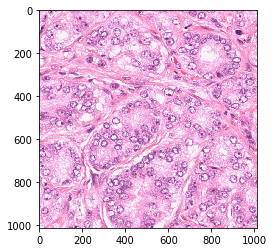

In [15]:
show(torchvision.utils.make_grid(inputs, 5))

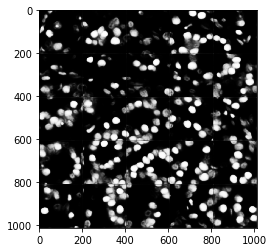

In [17]:
show(torchvision.utils.make_grid(outputs.cpu(), 5))

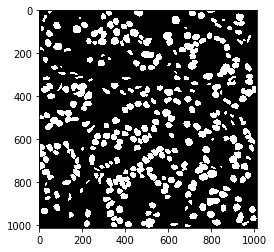

In [18]:
show(torchvision.utils.make_grid(masks, 5))